<a href="https://colab.research.google.com/github/elmidion/Bonescan_classification/blob/main/Bone_scan_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!python --version

Python 3.7.12


In [9]:
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as K
print(K.__version__)

2.7.0
2.7.0


In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 13.4 MB/s 


In [ ]:
!pip install image-classifiers

     |████████████████████████████████| 50 kB 5.1 MB/s 


In [ ]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import cv2
import datetime
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, BatchNormalization, GlobalAveragePooling2D
import gc
os.chdir('/content/drive/MyDrive/AI/PooltoBone')

In [ ]:
# os.chdir('/content/drive/MyDrive/AI/PooltoBone/Bonescan_detection_models')
# !ls 
# !rm *

In [ ]:
# !unzip Pool2Bone.zip

#DATA preparation

In [ ]:
DCM_Folder = '/content/drive/MyDrive/AI/PooltoBone/PBdata'

In [ ]:
PBlist = os.listdir(DCM_Folder)

Bone_dic = {}
bone_list = []   
index_ID = '00328734'
for file_dcm in PBlist[1:]:
  file_name = file_dcm.split('.')[0]
  File_property = file_name.split('_')
  if len(File_property) > 4:
    continue  
  # print(File_property)

  ID = File_property[0]
  if index_ID != ID:
    index_ID = ID
    bone_list = []
    if File_property[1] == 'bone':
      bone_list.append(file_dcm)

  else:
    if File_property[1] == 'bone':
      bone_list.append(file_dcm)
      Bone_dic[index_ID] = bone_list
   
  # break

In [ ]:
Bone_dic_AP = {}
for ID in Bone_dic:
  if len(Bone_dic[ID]) == 2:
    Bone_dic_AP[ID] = Bone_dic[ID]

In [ ]:
DATA_Table = pd.read_csv(os.path.join(DCM_Folder, 'Y_data_for_1079_20220107.csv'))

In [ ]:
DATA_Table

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,ID,Target,Disease_groups,ID_text,group
0,0,0,0,635,328734,1,2,328734,Test
1,1,1,1,16,618373,0,0,618373,Valid
2,2,2,2,909,2170741,1,2,2170741,Train
3,3,3,3,806,2307825,1,1,2307825,Train
4,4,4,4,706,2512466,1,5,2512466,Train
...,...,...,...,...,...,...,...,...,...
1067,1069,1074,1074,770,71918447,1,1,71918447,Train
1068,1070,1075,1075,728,71961354,1,2,71961354,Valid
1069,1071,1076,1076,155,71961902,1,3,71961902,Train
1070,1072,1077,1077,372,71961902,1,2,71961902,Train


In [ ]:
# DATA_Table['ID_text'] = DATA_Table['ID'].astype('str').str.zfill(8)

In [ ]:
Bone_dic_AP_list =list(Bone_dic_AP.keys())
DATA_Table_ID_list = DATA_Table['ID_text'].tolist()

DATA_list = list(set(Bone_dic_AP_list).intersection(set(DATA_Table_ID_list)))

In [ ]:
import random
from random import sample

BATCH_SIZE = 107
batch_size = BATCH_SIZE

# random.seed(20211230)
# np.random.seed(20211230)
# # Train_list = sample(DATA_list, 401)
# # Valid_list = sample(list(set(DATA_list) - set(Train_list)),50)
# # Test_list = list(set(DATA_list) - set(Train_list) - set(Valid_list))

# BATCH_SIZE = 10
# batch_size = BATCH_SIZE

# Train_list = sample(DATA_list, 708)
# Valid_list = sample(list(set(DATA_list) - set(Train_list)), 100)
# Test_list = list(set(DATA_list) - set(Train_list) - set(Valid_list))

def Split_DATA(seed=20211230):
  random.seed(seed)
  np.random.seed(seed)

  Train_list = sample(DATA_list, 833)
  Valid_list = sample(list(set(DATA_list) - set(Train_list)), 100)
  Test_list = list(set(DATA_list) - set(Train_list) - set(Valid_list))

  return Train_list, Valid_list, Test_list

#Generator

In [ ]:
def generator_fx(DATA_path, what, shuffle=True, batch_size=BATCH_SIZE):
  if shuffle:
    random.shuffle(what)

  while True:
    for j in range(int(len(what)//batch_size)):
      
      ### ResNet18
      Batch_X = np.zeros((batch_size, 224, 224, 3))
      Batch_Y = np.zeros((batch_size, 1))


      for i in range(batch_size):        
        
        case_ID = what[i+(batch_size*j)]
        
        # print(case_ID)
        DCM_data_A = pydicom.read_file(os.path.join(DATA_path, Bone_dic_AP[str(case_ID).zfill(8)][0]))
        DCM_data_B = pydicom.read_file(os.path.join(DATA_path, Bone_dic_AP[str(case_ID).zfill(8)][1]))
        
        IMAGE = np.c_[DCM_data_A.pixel_array, DCM_data_B.pixel_array]
        # plt.imshow(IMAGE)
        # print(IMAGE.shape)

        Y = DATA_Table[DATA_Table['ID_text'] == int(case_ID)]['Target'].values[0]
        # print(Y)

        ### ResNet18
        IMAGE_resize = cv2.resize(IMAGE, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        
        IMAGE_resize = IMAGE_resize.astype(np.uint8)
        # IMAGE_resize = cv2.equalizeHist(IMAGE_resize)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        IMAGE_resize = clahe.apply(IMAGE_resize)

        IMAGE_resize = cv2.cvtColor(IMAGE_resize, cv2.COLOR_GRAY2RGB) 

        Batch_X[i] = (IMAGE_resize - np.min(IMAGE_resize))/(np.max(IMAGE_resize) - np.min(IMAGE_resize))  
        # print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ ' + case_ID + '_' + str(Y))
        Batch_Y[i] = Y

      # Batch_X = np.expand_dims(Batch_X, axis=3)
      
      Batch_X = np.array(Batch_X)
      Batch_Y = np.array(Batch_Y)

      yield Batch_X, Batch_Y

In [ ]:
# Train_gen = generator_fx(DCM_Folder, Train_list)
# Valid_gen = generator_fx(DCM_Folder, Valid_list)
# Test_gen = generator_fx(DCM_Folder, Test_list, shuffle=False)

In [ ]:
from classification_models.tfkeras import Classifiers

def make_model(Model_name=None, LR = 0.01):
  pretrained_Model, preprocess_input = Classifiers.get(Model_name)
  # ResNet18, preprocess_input = Classifiers.get('resnet18')
  # X = preprocess_input(X)

  n_classes = 1

  #### build model
  ## ResNet18
  base_model = pretrained_Model(input_shape=(224,224,3), weights='imagenet', include_top=False)

  x = keras.layers.GlobalAveragePooling2D()(base_model.output)
  initializer = tf.keras.initializers.GlorotUniform()
  x = keras.layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
  x = keras.layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
  output = keras.layers.Dense(n_classes, activation='sigmoid', kernel_initializer=initializer)(x)
  model = keras.models.Model(inputs=[base_model.input], outputs=[output])

  opt = Adam(learning_rate = LR)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  return model

In [ ]:
from keras import layers

def residual_block(x, filters_in, filters_out, k_size):
    shortcut = x
    x = layers.Conv2D(filters_in, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv2D(filters_in, kernel_size=(k_size, k_size), strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)    
    
    x = layers.Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    print(x.shape.as_list())
    shortcut_channel = shortcut.shape.as_list()[-1]
    
    if shortcut_channel != filters_out:
        shortcut = layers.Conv2D(filters_out, kernel_size=(1, 1), strides=(1, 1), padding="same")(shortcut)
        
    x = layers.Add()([x, shortcut])
    return layers.LeakyReLU()(x)

def make_model(Model_name=None, LR = 0.01):
  n_classes = 1
  initializer = tf.keras.initializers.GlorotUniform()
  #### build model
  Inputs = layers.Input(shape=(224, 224, 3, ))
  x = residual_block(Inputs, 16, 32, 7)
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
  x = residual_block(x, 32, 64, 7)  
  x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) #AUC 0.619
  # x = residual_block(x, 64, 128, 7)  
  # x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x) 

  # model = Sequential()
  
  # model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
  # model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
  # model.add(Dropout(rate=0.2))
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))

  # model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(Conv2D(256, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
  
  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(Conv2D(512, (3, 3), strides=(1, 1), activation='relu'))
  # model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

  # model.add(GlobalAveragePooling2D())
  # model.add(Dense(128, activation='relu', kernel_initializer=initializer))
  # model.add(Dense(32, activation='relu', kernel_initializer=initializer))
  # model.add(Dense(n_classes, activation='sigmoid', kernel_initializer=initializer))

  # opt = Adam(learning_rate = LR)
  # model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  x = keras.layers.GlobalAveragePooling2D()(x)
  initializer = tf.keras.initializers.GlorotUniform()
  x = keras.layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
  x = keras.layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
  output = keras.layers.Dense(n_classes, activation='sigmoid', kernel_initializer=initializer)(x)
  model = keras.models.Model(inputs=[Inputs], outputs=[output])

  opt = Adam(learning_rate = LR)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  return model

In [ ]:
# temp_model = make_model('resnet18') 
# temp_model.summary()

In [ ]:
def make_graph(hist, title, pred_test, fpr, tpr):
  import matplotlib.pyplot as plt
 
  fig, ax = plt.subplots(3, 1, figsize=(6, 10))

  acc_ax = ax[2].twinx()

  ax[2].plot(hist.history['loss'], 'y', label='train loss')
  ax[2].plot(hist.history['val_loss'], 'r', label='val loss')

  acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
  acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

  ax[2].set_xlabel('epoch')
  ax[2].set_ylabel('loss')
  acc_ax.set_ylabel('accuray')
  ax[2].set_title('Learning curve')

  ax[2].legend(loc='upper left')
  acc_ax.legend(loc='lower left')

  ax[1].hist(pred_test)
  ax[1].set_xlim(0, 1)
  ax[1].set_title('Prediction histogram')

  ax[0].plot(fpr,tpr) 
  ax[0].plot([0,1], [0,1], linestyle='--')
  ax[0].set_xlabel('False positive rate') 
  ax[0].set_ylabel('True positive rate') 
  ax[0].legend(["AUC=%.3f"%auc])

  fig.suptitle(title)
  # plt.show()
  return plt

In [ ]:
# File_ex_list = list(Bone_dic_AP.keys())
# # DATA_Table[DATA_Table['ID_text'].isin(File_ex_list)] /.to_csv(os.path.join(DCM_Folder, 'Y_data_for_1079_20220107.csv'))

In [ ]:
# DATA_Table['Target'].value_counts()
# Normal_list = DATA_Table[DATA_Table['Target'] == 0]['ID_text'].tolist()
# random.shuffle(Normal_list)
# len(Normal_list)

# Abnormal_list = DATA_Table[DATA_Table['Target'] == 1]['ID_text'].tolist()
# random.shuffle(Abnormal_list)
# len(Abnormal_list)

# Train_list = Normal_list[:78] + Abnormal_list[:601]
# Valid_list = Normal_list[78:98] + Abnormal_list[601:781]
# Test_list = Normal_list[98:118] + Abnormal_list[781:961]

# Train_list = DATA_Table[DATA_Table['group'] == 'Train']['ID_text'].astype(str).str.zfill(8).tolist()
# Valid_list = DATA_Table[DATA_Table['group'] == 'Valid']['ID_text'].astype(str).str.zfill(8).tolist()
# Test_list = DATA_Table[DATA_Table['group'] == 'Test']['ID_text'].astype(str).str.zfill(8).tolist()

Train_list = DATA_Table[DATA_Table['group'] == 'Train']['ID_text'].tolist()
Valid_list = DATA_Table[DATA_Table['group'] == 'Valid']['ID_text'].tolist()
Test_list = DATA_Table[DATA_Table['group'] == 'Test']['ID_text'].tolist()

# Train_list = Train_list[:600]
# Valid_list = Valid_list[:200]
# Test_list = Test_list[:200]

In [ ]:
# DATA_Table['group'] = 'Train'

# # print('Train_list: ' + str(len(Train_list)))
# # DATA_Table[DATA_Table['ID_text'].isin(Train_list)]

# # print('Valid_list: ' + str(len(Valid_list)))
# DATA_Table.loc[DATA_Table['ID_text'].isin(Valid_list), 'group'] = 'Valid'
# # print('Test_list: ' + str(len(Test_list)))
# DATA_Table.loc[DATA_Table['ID_text'].isin(Test_list), 'group'] = 'Test'

# DATA_Table.groupby(['group'])['Target'].value_counts()
# # DATA_Table.to_csv(os.path.join(DCM_Folder, 'Y_data_for_1079_20220106.csv'))

In [ ]:
# from sklearn.model_selection import StratifiedKFold

# seed = 20220103
# Train_list, Valid_list, Test_list = Split_DATA(seed)

print('Train Data')
print(DATA_Table[DATA_Table['group'] == 'Train']['Target'].value_counts())
print('Valid Data')
print(DATA_Table[DATA_Table['group'] == 'Valid']['Target'].value_counts())
print('Test Data')
print(DATA_Table[DATA_Table['group'] == 'Test']['Target'].value_counts())

# Train_gen = generator_fx(DCM_Folder, Train_list, batch_size=BATCH_SIZE)
# Valid_gen = generator_fx(DCM_Folder, Valid_list, batch_size=BATCH_SIZE)
# Test_gen = generator_fx(DCM_Folder, Test_list, shuffle=False, batch_size=BATCH_SIZE)

###Extract Test_Y
print(DATA_Table[DATA_Table['ID_text'].isin(Test_list)]['Target'].value_counts())
Test_Y = DATA_Table[DATA_Table['ID_text'].isin(Test_list)]['Target'].tolist()
Test_Y = np.array(Test_Y)

# Test_Y = []
# for Test_id in Test_list:
#   # print(Test_id)
#   ID = Test_id
#   ANS_Y = DATA_Table[DATA_Table['ID_text'] == ID]['Target'].values[0]
#   Test_Y.append(ANS_Y)
# Test_Y = np.array(Test_Y)
# print(pd.DataFrame(Test_Y).value_counts())

Train Data
1    578
0     76
Name: Target, dtype: int64
Valid Data
1    183
0     21
Name: Target, dtype: int64
Test Data
1    193
0     21
Name: Target, dtype: int64
1    193
0     21
Name: Target, dtype: int64


# 전처리 테스트

In [ ]:
# def test_generator_fx(DATA_path, what, shuffle=True, batch_size=BATCH_SIZE):
#   if shuffle:
#     random.shuffle(what)

#   while True:
#     for j in range(int(len(what)//batch_size)):
      
#       ### ResNet18
#       Batch_X_original = np.zeros((batch_size, 224, 224, 3))
#       Batch_X_HE = np.zeros((batch_size, 224, 224, 3))
#       Batch_X_CLAHE = np.zeros((batch_size, 224, 224, 3))
#       Batch_X_HE_CLAHE = np.zeros((batch_size, 224, 224, 3))
#       Batch_Y = np.zeros((batch_size, 1))


#       for i in range(batch_size):        
        
#         case_ID = what[i+(batch_size*j)]
        
#         # print(case_ID)
#         DCM_data_A = pydicom.read_file(os.path.join(DATA_path, Bone_dic_AP[str(case_ID).zfill(8)][0]))
#         DCM_data_B = pydicom.read_file(os.path.join(DATA_path, Bone_dic_AP[str(case_ID).zfill(8)][1]))
        
#         IMAGE = np.c_[DCM_data_A.pixel_array, DCM_data_B.pixel_array]
#         # plt.imshow(IMAGE)
#         # print(IMAGE.shape)

#         Y = DATA_Table[DATA_Table['ID_text'] == int(case_ID)]['Target'].values[0]
#         # print(Y)

#         ### ResNet18
#         IMAGE_resize_original = cv2.resize(IMAGE, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        
#         ## Original
#         IMAGE_resize_original = IMAGE_resize_original.astype(np.uint8)

#         ## HE
#         IMAGE_resize_HE = cv2.equalizeHist(IMAGE_resize_original)

#         ## CLAHE
#         clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
#         IMAGE_resize_CLAHE = clahe.apply(IMAGE_resize_original)

#         ## HE_CLAHE
#         clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
#         IMAGE_resize_HE_CLAHE = clahe.apply(IMAGE_resize_HE)

#         IMAGE_resize_original = cv2.cvtColor(IMAGE_resize_original, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_HE = cv2.cvtColor(IMAGE_resize_HE, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_CLAHE = cv2.cvtColor(IMAGE_resize_CLAHE, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_HE_CLAHE = cv2.cvtColor(IMAGE_resize_HE_CLAHE, cv2.COLOR_GRAY2RGB) 
      
#         Batch_X_original[i] = 1 - (IMAGE_resize_original - np.min(IMAGE_resize_original))/(np.max(IMAGE_resize_original) - np.min(IMAGE_resize_original))  
#         Batch_X_HE[i] = 1 - (IMAGE_resize_HE - np.min(IMAGE_resize_HE))/(np.max(IMAGE_resize_HE) - np.min(IMAGE_resize_HE))  
#         Batch_X_CLAHE[i] = 1 - (IMAGE_resize_CLAHE - np.min(IMAGE_resize_CLAHE))/(np.max(IMAGE_resize_CLAHE) - np.min(IMAGE_resize_CLAHE))  
#         Batch_X_HE_CLAHE[i] = 1 - (IMAGE_resize_HE_CLAHE - np.min(IMAGE_resize_HE_CLAHE))/(np.max(IMAGE_resize_HE_CLAHE) - np.min(IMAGE_resize_HE_CLAHE))  
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ ' + str(case_ID) + '_' + str(Y))
#         Batch_Y[i] = Y

#       # Batch_X = np.expand_dims(Batch_X, axis=3)
      
#       Batch_X_original = np.array(Batch_X_original)
#       Batch_X_HE = np.array(Batch_X_HE)
#       Batch_X_CLAHE = np.array(Batch_X_CLAHE)
#       Batch_X_HE_CLAHE = np.array(Batch_X_HE_CLAHE)
#       Batch_Y = np.array(Batch_Y)

#       yield Batch_X_original, Batch_X_HE, Batch_X_CLAHE, Batch_X_HE_CLAHE, Batch_Y

In [ ]:
# Tmp_gen = test_generator_fx(DCM_Folder, Train_list, batch_size=1)

In [ ]:
# TMP_case = next(Tmp_gen)
# plt.figure(figsize=(20,20))

# plt.title('Original')
# plt.subplot(4,2,1)
# plt.imshow(TMP_case[0][0])
# plt.title('Original_hist')
# plt.subplot(4,2,2)
# plt.hist(TMP_case[0][0].ravel(), 256, [0,1])

# plt.title('HE')
# plt.subplot(4,2,3)
# plt.imshow(TMP_case[1][0])
# plt.title('HE_hist')
# plt.subplot(4,2,4)
# plt.hist(TMP_case[1][0].ravel(), 256, [0,1])

# plt.title('CLAHE')
# plt.subplot(4,2,5)
# plt.imshow(TMP_case[2][0])
# plt.title('CLAHE_hist')
# plt.subplot(4,2,6)
# plt.hist(TMP_case[2][0].ravel(), 256, [0,1])

# plt.title('HE_CLAHE')
# plt.subplot(4,2,7)
# plt.imshow(TMP_case[3][0])
# plt.title('HE_CLAHE_hist')
# plt.subplot(4,2,8)
# plt.hist(TMP_case[3][0].ravel(), 256, [0,1])

In [ ]:
# def clahe_generator_fx(DATA_path, what, shuffle=True, batch_size=BATCH_SIZE):
#   if shuffle:
#     random.shuffle(what)

#   while True:
#     for j in range(int(len(what)//batch_size)):
      
#       ### ResNet18
#       Batch_X_original = np.zeros((batch_size, 224, 224, 3))      
#       Batch_X_CLAHE_01 = np.zeros((batch_size, 224, 224, 3))
#       Batch_X_CLAHE_001 = np.zeros((batch_size, 224, 224, 3))
#       Batch_X_CLAHE_05 = np.zeros((batch_size, 224, 224, 3))
#       Batch_X_CLAHE_10 = np.zeros((batch_size, 224, 224, 3))
#       Batch_X_CLAHE_20 = np.zeros((batch_size, 224, 224, 3))      
#       Batch_Y = np.zeros((batch_size, 1))


#       for i in range(batch_size):        
        
#         case_ID = what[i+(batch_size*j)]
        
#         # print(case_ID)
#         DCM_data_A = pydicom.read_file(os.path.join(DATA_path, Bone_dic_AP[str(case_ID).zfill(8)][0]))
#         DCM_data_B = pydicom.read_file(os.path.join(DATA_path, Bone_dic_AP[str(case_ID).zfill(8)][1]))
        
#         IMAGE = np.c_[DCM_data_A.pixel_array, DCM_data_B.pixel_array]
#         # plt.imshow(IMAGE)
#         # print(IMAGE.shape)

#         Y = DATA_Table[DATA_Table['ID_text'] == int(case_ID)]['Target'].values[0]
#         # print(Y)

#         ### ResNet18
#         IMAGE_resize_original = cv2.resize(IMAGE, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        
#         ## Original
#         IMAGE_resize_original = IMAGE_resize_original.astype(np.uint8)       
       
#         ## CLAHE_0.5
#         clahe_05 = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
#         IMAGE_resize_CLAHE_05 = clahe_05.apply(IMAGE_resize_original)

#         ## CLAHE_1.0
#         clahe_10 = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
#         IMAGE_resize_CLAHE_10 = clahe_10.apply(IMAGE_resize_original)

#         ## CLAHE_2.0
#         clahe_20 = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         IMAGE_resize_CLAHE_20 = clahe_20.apply(IMAGE_resize_original)

#         ## CLAHE_0.1
#         clahe_01 = cv2.createCLAHE(clipLimit=0.1, tileGridSize=(8,8))
#         IMAGE_resize_CLAHE_01 = clahe_01.apply(IMAGE_resize_original)

#         ## CLAHE_0.01
#         clahe_001 = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(8,8))
#         IMAGE_resize_CLAHE_001 = clahe_001.apply(IMAGE_resize_original)

#         IMAGE_resize_original = cv2.cvtColor(IMAGE_resize_original, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_CLAHE_01 = cv2.cvtColor(IMAGE_resize_CLAHE_01, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_CLAHE_001 = cv2.cvtColor(IMAGE_resize_CLAHE_001, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_CLAHE_05 = cv2.cvtColor(IMAGE_resize_CLAHE_05, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_CLAHE_10 = cv2.cvtColor(IMAGE_resize_CLAHE_10, cv2.COLOR_GRAY2RGB) 
#         IMAGE_resize_CLAHE_20 = cv2.cvtColor(IMAGE_resize_CLAHE_20, cv2.COLOR_GRAY2RGB) 
      
#         Batch_X_original[i] = 1 - (IMAGE_resize_original - np.min(IMAGE_resize_original))/(np.max(IMAGE_resize_original) - np.min(IMAGE_resize_original))  
#         # Batch_X_HE[i] = 1 - (IMAGE_resize_HE - np.min(IMAGE_resize_HE))/(np.max(IMAGE_resize_HE) - np.min(IMAGE_resize_HE))  
#         Batch_X_CLAHE_01[i] = 1 - (IMAGE_resize_CLAHE_01 - np.min(IMAGE_resize_CLAHE_01))/(np.max(IMAGE_resize_CLAHE_01) - np.min(IMAGE_resize_CLAHE_01))  
#         Batch_X_CLAHE_001[i] = 1 - (IMAGE_resize_CLAHE_001 - np.min(IMAGE_resize_CLAHE_001))/(np.max(IMAGE_resize_CLAHE_001) - np.min(IMAGE_resize_CLAHE_001))  
#         Batch_X_CLAHE_05[i] = 1 - (IMAGE_resize_CLAHE_05 - np.min(IMAGE_resize_CLAHE_05))/(np.max(IMAGE_resize_CLAHE_05) - np.min(IMAGE_resize_CLAHE_05))  
#         Batch_X_CLAHE_10[i] = 1 - (IMAGE_resize_CLAHE_10 - np.min(IMAGE_resize_CLAHE_10))/(np.max(IMAGE_resize_CLAHE_10) - np.min(IMAGE_resize_CLAHE_10))  
#         Batch_X_CLAHE_20[i] = 1 - (IMAGE_resize_CLAHE_20 - np.min(IMAGE_resize_CLAHE_20))/(np.max(IMAGE_resize_CLAHE_20) - np.min(IMAGE_resize_CLAHE_20))  
        
#         # Batch_X_HE_CLAHE[i] = 1 - (IMAGE_resize_HE_CLAHE - np.min(IMAGE_resize_HE_CLAHE))/(np.max(IMAGE_resize_HE_CLAHE) - np.min(IMAGE_resize_HE_CLAHE))  
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ ' + str(case_ID) + '_' + str(Y))
#         Batch_Y[i] = Y

#       # Batch_X = np.expand_dims(Batch_X, axis=3)
      
#       Batch_X_original = np.array(Batch_X_original)
#       # Batch_X_HE = np.array(Batch_X_HE)
#       Batch_X_CLAHE_01 = np.array(Batch_X_CLAHE_01)
#       Batch_X_CLAHE_001 = np.array(Batch_X_CLAHE_001)
#       Batch_X_CLAHE_05 = np.array(Batch_X_CLAHE_05)
#       Batch_X_CLAHE_10 = np.array(Batch_X_CLAHE_10)
#       Batch_X_CLAHE_20 = np.array(Batch_X_CLAHE_20)
#       # Batch_X_HE_CLAHE = np.array(Batch_X_HE_CLAHE)
#       Batch_Y = np.array(Batch_Y)

#       # yield Batch_X_original, Batch_X_HE, Batch_X_CLAHE, Batch_X_HE_CLAHE, Batch_Y
#       yield Batch_X_original, Batch_X_CLAHE_05, Batch_X_CLAHE_10, Batch_X_CLAHE_20, Batch_X_CLAHE_01, Batch_X_CLAHE_001,Batch_Y

In [ ]:
# Tmp_clahe_gen = clahe_generator_fx(DCM_Folder, Train_list, batch_size=1)

In [ ]:
# TMP_clahe_case = next(Tmp_clahe_gen)
# plt.figure(figsize=(20,20))

# plt.subplot(6,2,1)
# plt.imshow(TMP_clahe_case[0][0])
# plt.title('Original')
# plt.subplot(6,2,2)
# plt.hist(TMP_clahe_case[0][0].ravel(), 256, [0,1])
# plt.title('Original_hist')
# plt.ylim(0,1000)

# plt.subplot(6,2,3)
# plt.imshow(TMP_clahe_case[1][0])
# plt.title('CLAHE_0.5')
# plt.subplot(6,2,4)
# plt.hist(TMP_clahe_case[1][0].ravel(), 256, [0,1])
# plt.title('CLAHE_0.5_hist')
# plt.ylim(0,1000)

# plt.subplot(6,2,5)
# plt.imshow(TMP_clahe_case[2][0])
# plt.title('CLAHE_1.0')
# plt.subplot(6,2,6)
# plt.hist(TMP_clahe_case[2][0].ravel(), 256, [0,1])
# plt.title('CLAHE_1.0_hist')
# plt.ylim(0,1000)

# plt.subplot(6,2,7)
# plt.imshow(TMP_clahe_case[3][0])
# plt.title('CLAHE_2.0')
# plt.subplot(6,2,8)
# plt.hist(TMP_clahe_case[3][0].ravel(), 256, [0,1])
# plt.title('CLAHE_2.0_hist')
# plt.ylim(0,1000)

# plt.subplot(6,2,9)
# plt.imshow(TMP_clahe_case[4][0])
# plt.title('CLAHE_0.1')
# plt.subplot(6,2,10)
# plt.hist(TMP_clahe_case[4][0].ravel(), 256, [0,1])
# plt.title('CLAHE_0.1_hist')
# plt.ylim(0,1000)

# plt.subplot(6,2,11)
# plt.imshow(TMP_clahe_case[5][0])
# plt.title('CLAHE_0.01')
# plt.subplot(6,2,12)
# plt.hist(TMP_clahe_case[5][0].ravel(), 256, [0,1])
# plt.title('CLAHE_0.01_hist')
# plt.ylim(0,1000)

# 모델 훈련

{0: 10, 1: 1}_0.0001_0
[None, 224, 224, 32]
[None, 112, 112, 64]
Epoch 1/100
6/6 [==============================] - 19s 1s/step - loss: 1.3965 - accuracy: 0.1168 - val_loss: 0.6902 - val_accuracy: 0.8972
Epoch 2/100
6/6 [==============================] - 9s 2s/step - loss: 1.3779 - accuracy: 0.1277 - val_loss: 0.6905 - val_accuracy: 0.8972
Epoch 3/100
6/6 [==============================] - 11s 2s/step - loss: 1.3687 - accuracy: 0.1822 - val_loss: 0.6906 - val_accuracy: 0.8972
Epoch 4/100
6/6 [==============================] - 11s 2s/step - loss: 1.3611 - accuracy: 0.2290 - val_loss: 0.6917 - val_accuracy: 0.7383
Epoch 5/100
6/6 [==============================] - 11s 2s/step - loss: 1.3536 - accuracy: 0.2477 - val_loss: 0.6939 - val_accuracy: 0.3738
Epoch 6/100
6/6 [==============================] - 11s 2s/step - loss: 1.3452 - accuracy: 0.2523 - val_loss: 0.6957 - val_accuracy: 0.2617
Epoch 7/100
6/6 [==============================] - 11s 2s/step - loss: 1.3361 - accuracy: 0.2648 - val

ValueError: ignored

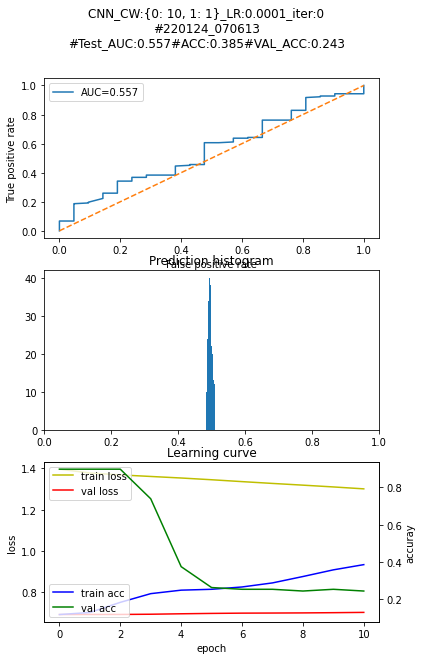

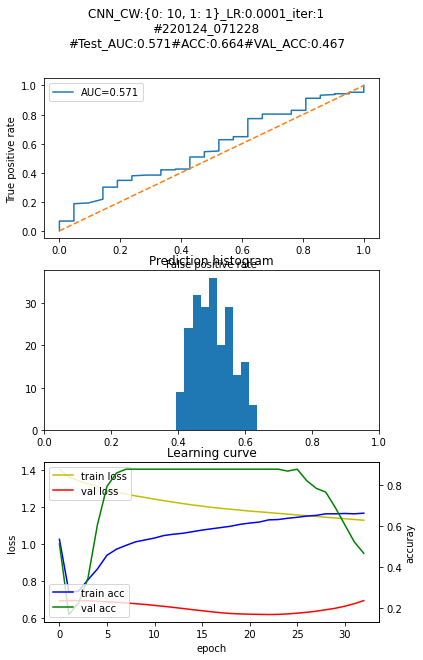

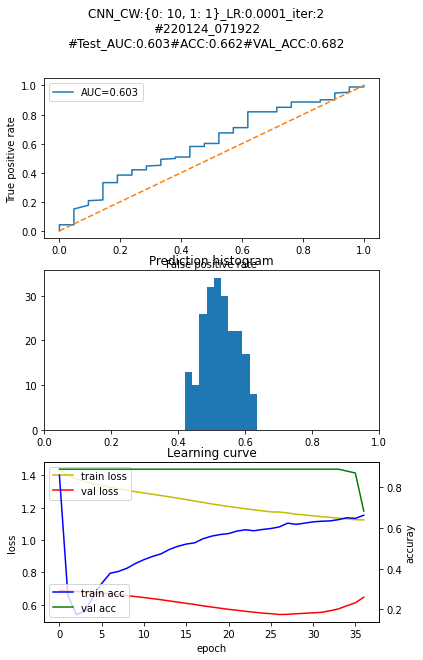

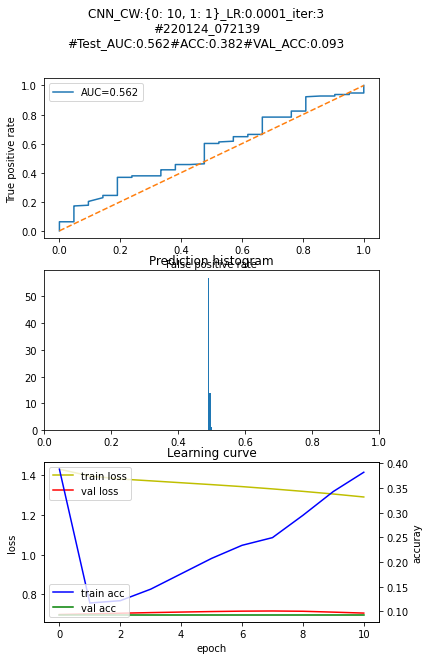

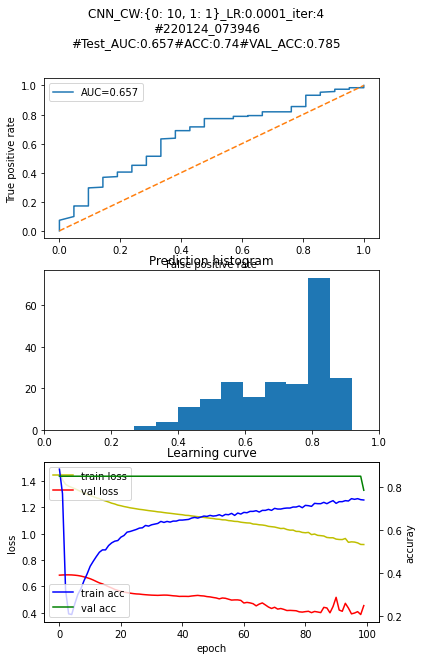

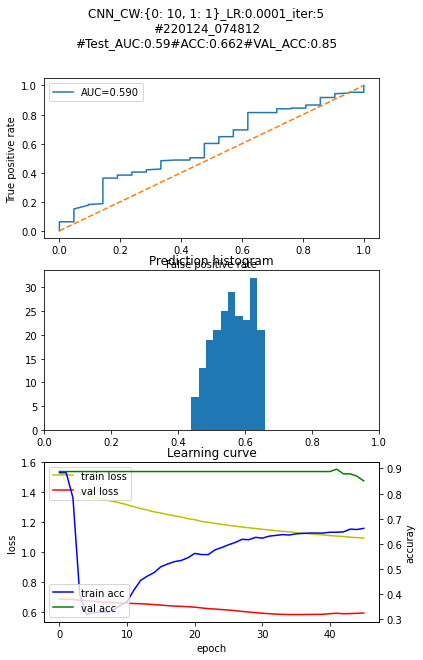

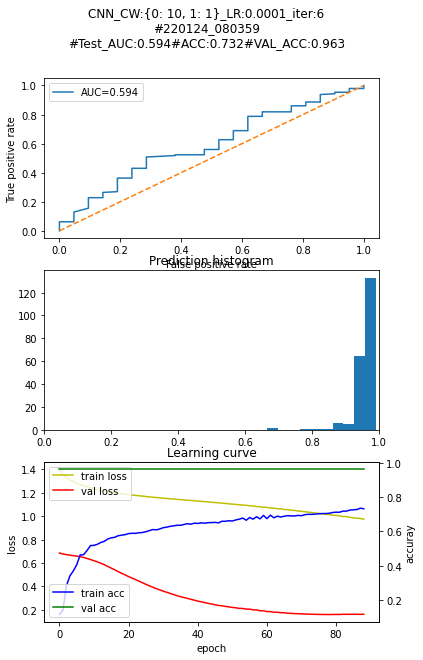

In [ ]:
# CLASS_WEIGHT_s = [{0:1, 1:1}, {0:5, 1:1}, {0:10, 1:1}, {0:15, 1:1}]
CLASS_WEIGHT_s = [{0:10, 1:1}]
n_iter = 15
# n_iter = 15
# BATCH_SIZE = 107
# BATCH_SIZE = 30

# MODEL_NAME = 'resnet18'
# MODEL_NAME = 'vgg16'
# MODEL_NAME = 'densenet121'
# MODEL_NAME = 'inceptionv3'
MODEL_NAME = 'CNN'

Learning_rate_list = [1e-4]
# Learning_rate_list = [1e-3, 1e-4]

# Learning_rate_list = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

for CLASS_WEIGHT in CLASS_WEIGHT_s:
    
  for Learning_rate in  Learning_rate_list:  
    MODEL_NAME_s = []
    Learning_rate_s = []
    iter_s = []

    AUC_s = []
    Test_ACC_s = []
    Test_loss_s = []

    ACC_s = []
    VAL_ACC_s = []
    LOSS_s = []
    VAL_LOSS_s = []

    for iter in range(n_iter):
      print(str(CLASS_WEIGHT) + '_' + str(Learning_rate) + '_' + str(iter))
      # Train_list, Valid_list, Test_list = Split_DATA(iter)

      Train_gen = generator_fx(DCM_Folder, Train_list, batch_size=BATCH_SIZE)
      Valid_gen = generator_fx(DCM_Folder, Valid_list, batch_size=BATCH_SIZE)
      Test_gen = generator_fx(DCM_Folder, Test_list, shuffle=False, batch_size=BATCH_SIZE)

      # print('Train: ' + str(len(Train_list)))
      # print('Valid: ' + str(len(Valid_list)))
      # print('Test: ' + str(len(Test_list)))

      # ###Extract Test_Y
      # Test_Y = []
      # for Test_id in Test_list:
      #   # print(Test_id)
      #   ID = Test_id
      #   ANS_Y = DATA_Table[DATA_Table['ID_text'] == ID]['Target'].values[0]
      #   Test_Y.append(ANS_Y)
      # Test_Y = np.array(Test_Y)

      ### Define generators
      
      model = make_model(Model_name=MODEL_NAME, LR = Learning_rate)
      # model.summary()    
      
      # Checkpoint =ModelCheckpoint('/content/drive/MyDrive/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset' ,monitor = 'loss', mode = 'auto', save_best_only = True, save_weights_only = True )
      early_stopping = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min')
      # class_weight = {0:2, 1:2, 2:1}
      hist = model.fit(Train_gen, batch_size=BATCH_SIZE, epochs = 100, verbose = 1, steps_per_epoch=(len(Train_list)//BATCH_SIZE),
                        class_weight = CLASS_WEIGHT,
                      validation_data=Valid_gen, validation_steps=(len(Valid_list)//BATCH_SIZE),                       
                      callbacks=[early_stopping]
                      )

      Test_loss, Test_ACC = model.evaluate(Test_gen, steps=len(Test_list)//batch_size)
      
      # Test_gen = generator_fx(DCM_Folder, Test_list, shuffle=False)
      pred_test = model.predict(Test_gen, steps=len(Test_list)//batch_size)

      auc = roc_auc_score(Test_Y.flatten().astype(np.bool), pred_test.flatten())
      fpr, tpr, _ = roc_curve(Test_Y.flatten().astype(np.bool), pred_test.flatten())    
      
      model_save_path = '/content/drive/MyDrive/AI/PooltoBone/Bonescan_detection_models'

      dt_datetime = datetime.datetime.now()
      format = '%y%m%d_%H%M%S'
      str_datetime = datetime.datetime.strftime(dt_datetime, format)
      # print(str_datetime)

      MODEL_SETTING = MODEL_NAME + '_CW:' + str(CLASS_WEIGHT) + '_LR:' + str(Learning_rate) + '_iter:' + str(iter)
      MODEL_SAVE_NAME = MODEL_SETTING +'_#' + str_datetime + '#Test_AUC:' + str(round(auc,3)) + '#ACC:' + str(round(hist.history['accuracy'][-1],3)) + '#VAL_ACC:' + str(round(hist.history['val_accuracy'][-1],3)) 
      MODEL_TITLE = MODEL_SETTING + '\n' + '#' + str_datetime + '\n' + '#Test_AUC:' + str(round(auc,3)) + '#ACC:' + str(round(hist.history['accuracy'][-1],3)) + '#VAL_ACC:' + str(round(hist.history['val_accuracy'][-1],3))
      # model.save(os.path.join(model_save_path, MODEL_SAVE_NAME + '.h5'))

      Train_valid_graph = make_graph(hist, MODEL_TITLE, pred_test, fpr, tpr)
      # Train_valid_graph.close()
      Train_valid_graph.savefig(os.path.join(model_save_path, MODEL_SAVE_NAME + '.png'))

      MODEL_NAME_s.append(MODEL_NAME)
      Learning_rate_s.append(Learning_rate)
      iter_s.append(iter)
      
      AUC_s.append(round(auc,3))
      Test_ACC_s.append(round(Test_ACC,3))
      Test_loss_s.append(Test_loss)

      ACC_s.append(round(hist.history['accuracy'][-1],3))
      VAL_ACC_s.append(round(hist.history['val_accuracy'][-1],3))
      LOSS_s.append(hist.history['loss'][-1])
      VAL_LOSS_s.append(hist.history['val_loss'][-1])

      Resutl_table = pd.DataFrame({'Model': MODEL_NAME_s,
                    'LR': Learning_rate_s,
                    'iter': iter_s,
                    
                    'Test_AUC': AUC_s,
                    'Test_ACC': Test_ACC_s,
                    'Test_LOSS': Test_loss_s,
                    
                    'ACC': ACC_s,
                    'VAL_ACC': VAL_ACC_s,
                    'LOSS': LOSS_s,
                    'VAL_LOSS': VAL_LOSS_s
                    })

      Resutl_table.to_excel(os.path.join(model_save_path, 'CH_2.0_' + MODEL_NAME + '_CW:' + str(CLASS_WEIGHT) + '_LR:' + str(Learning_rate) + '_results.xlsx'))

      del model
      del hist
      del Train_valid_graph
      del Resutl_table

      del Train_gen
      del Valid_gen
      del Test_gen

      # del Batch_X
      # del Batch_Y

      # del case_ID

      # del DCM_data_A
      # del DCM_data_B
        
      # del IMAGE
      # del Y
      # del IMAGE_resize
      # del clahe
            
      gc.collect()

In [ ]:
batch_size

In [ ]:
# DCMpath
print(Bone_dic_AP['10957085'])
pydicom.read_file(os.path.join(DCM_Folder, Bone_dic_AP['10957085'][0]))

In [ ]:
DATA_Table[DATA_Table['ID_text'] == 10957085]['Target']

In [ ]:
if '10957085' in Bone_dic_AP.keys():
  print('y')

# 결과분석

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving VGG16_result.csv to VGG16_result.csv


In [ ]:
import pandas as pd

VGG16_result = pd.read_csv('/content/VGG16_result.csv')

In [ ]:
import scipy.stats

AUC_No = VGG16_result[VGG16_result['Prepara_method'] == 'No']['Test_AUC']
AUC_EH = VGG16_result[VGG16_result['Prepara_method'] == 'EH']['Test_AUC']
AUC_CH = VGG16_result[VGG16_result['Prepara_method'] == 'CH_6.0']['Test_AUC']

print('No vs EH:', scipy.stats.ttest_ind(AUC_No, AUC_EH, equal_var=False))
print('No vs CH:', scipy.stats.ttest_ind(AUC_No, AUC_CH, equal_var=False))
print('EH vs CH:', scipy.stats.ttest_ind(AUC_EH, AUC_CH, equal_var=False))

No vs EH: Ttest_indResult(statistic=-0.48324190422459196, pvalue=0.6334156420469971)
No vs CH: Ttest_indResult(statistic=-7.188689090858435, pvalue=1.1672335927226712e-07)
EH vs CH: Ttest_indResult(statistic=-4.566047143468299, pvalue=0.00018644008618465464)
